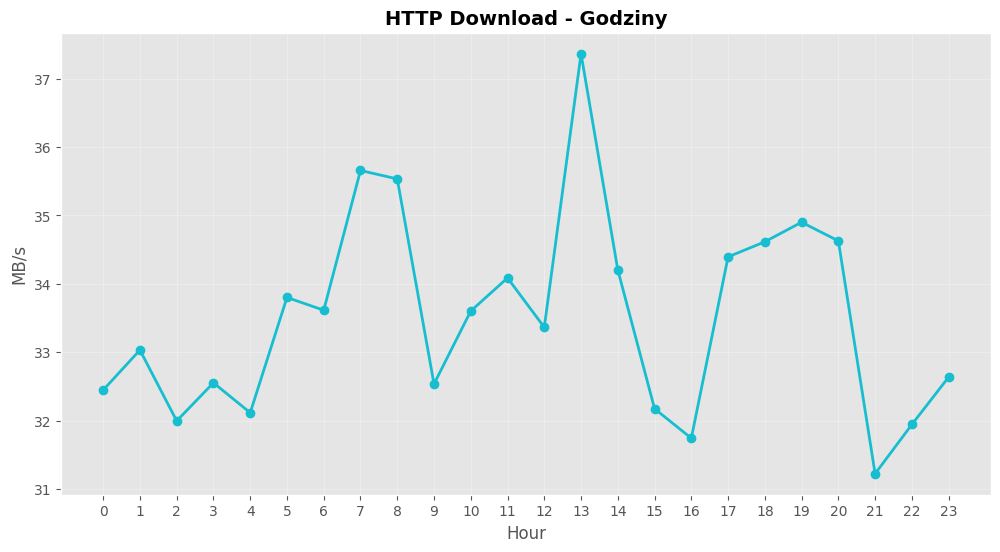

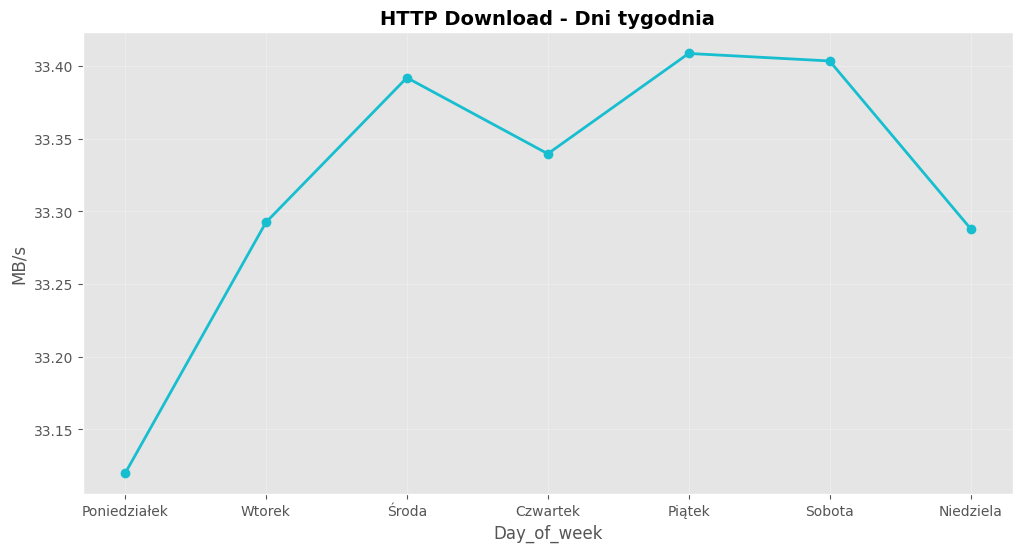

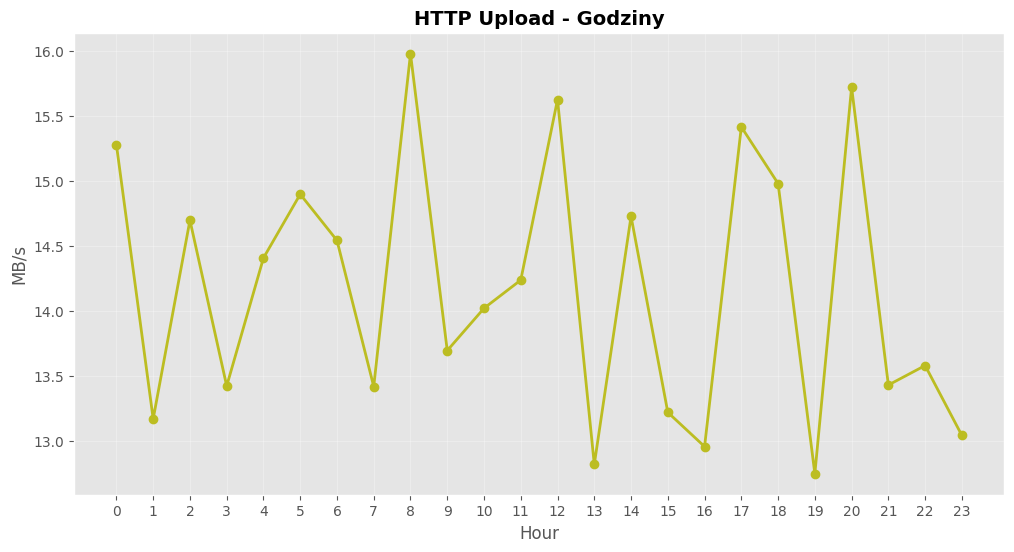

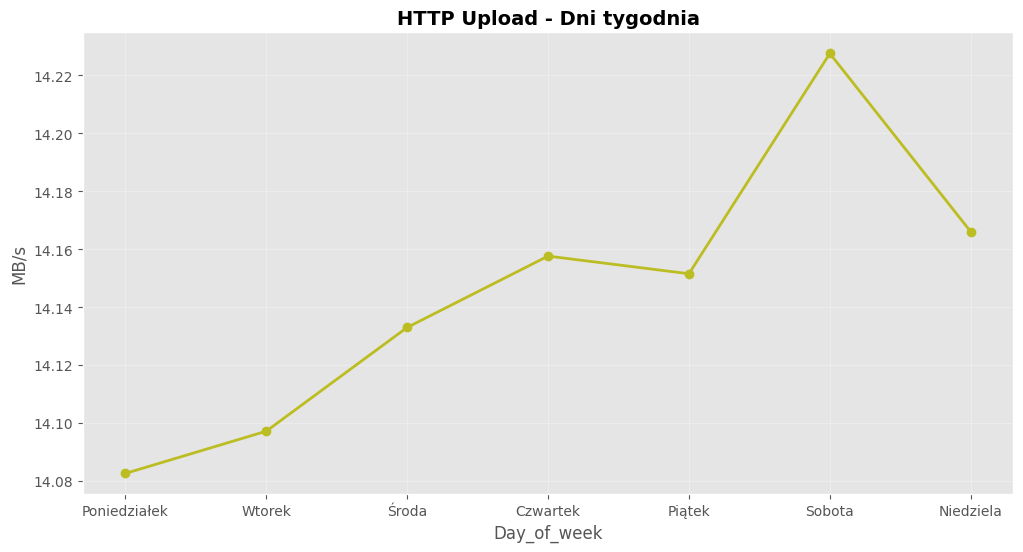

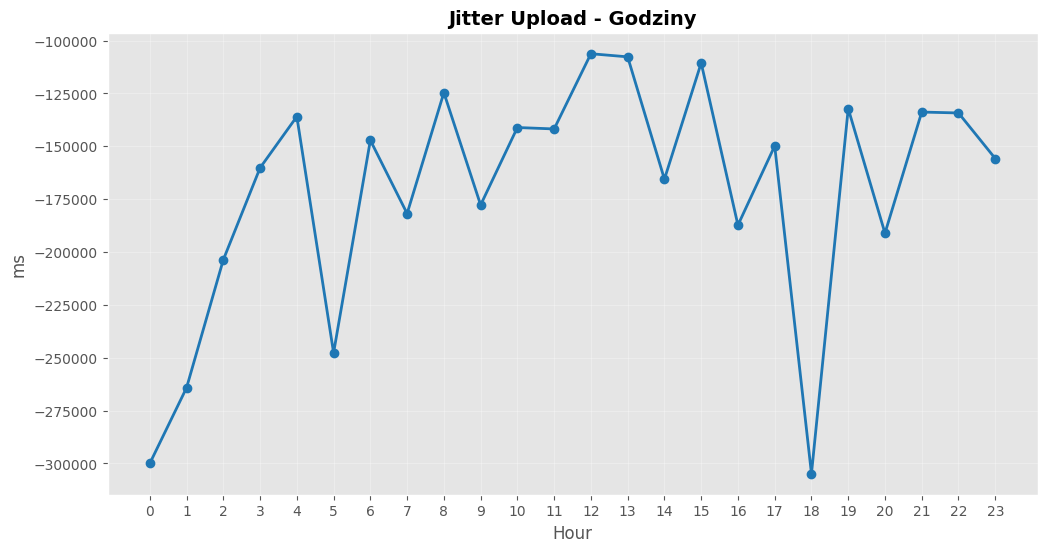

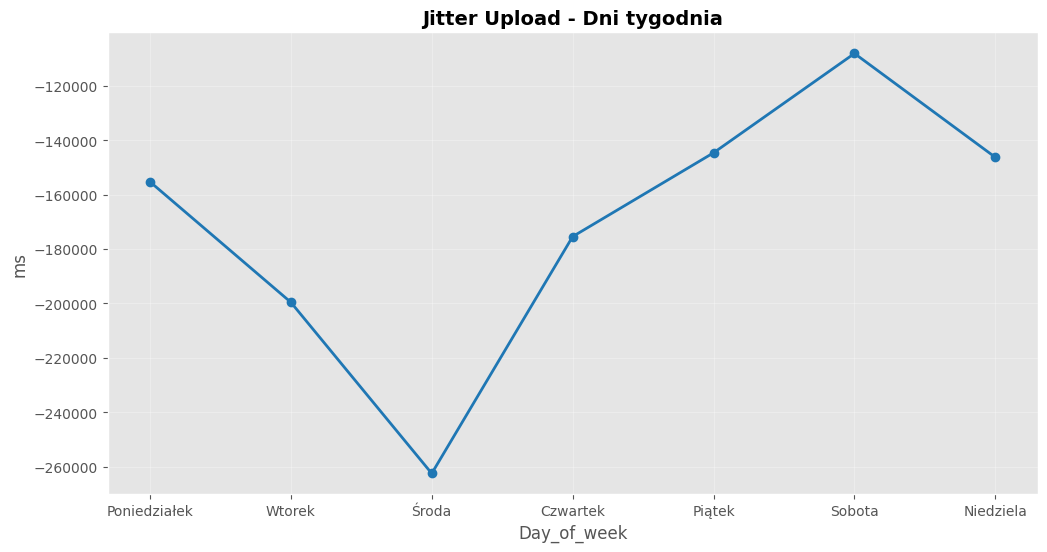

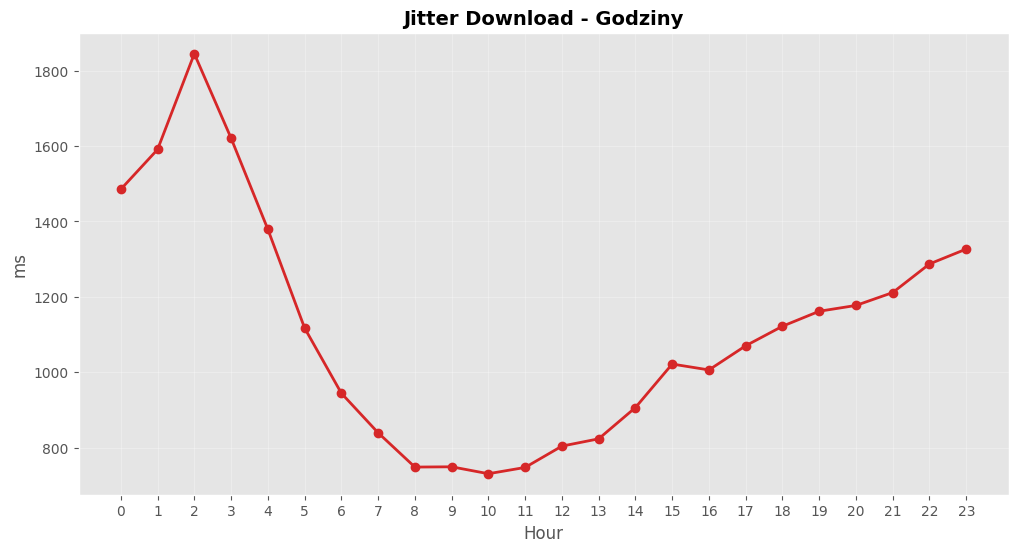

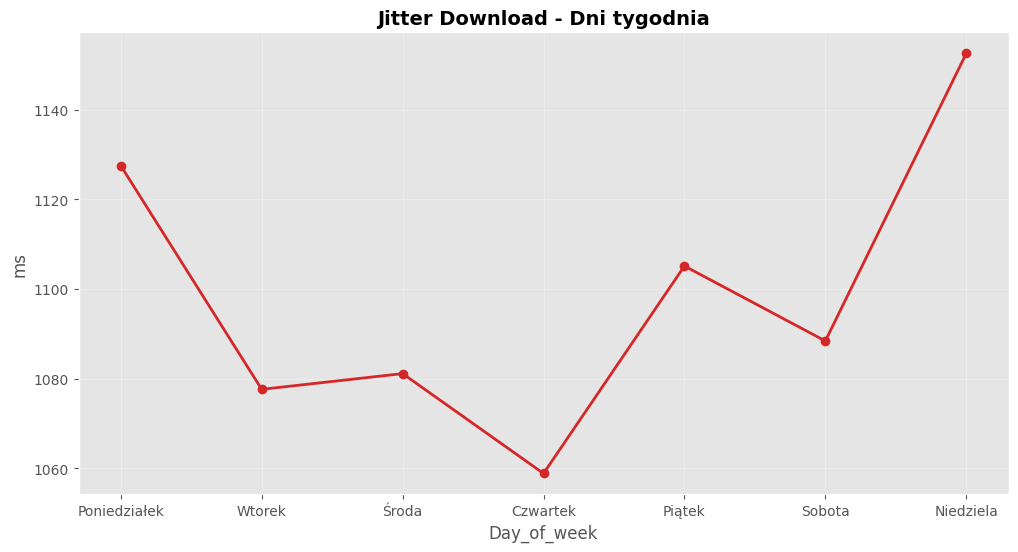

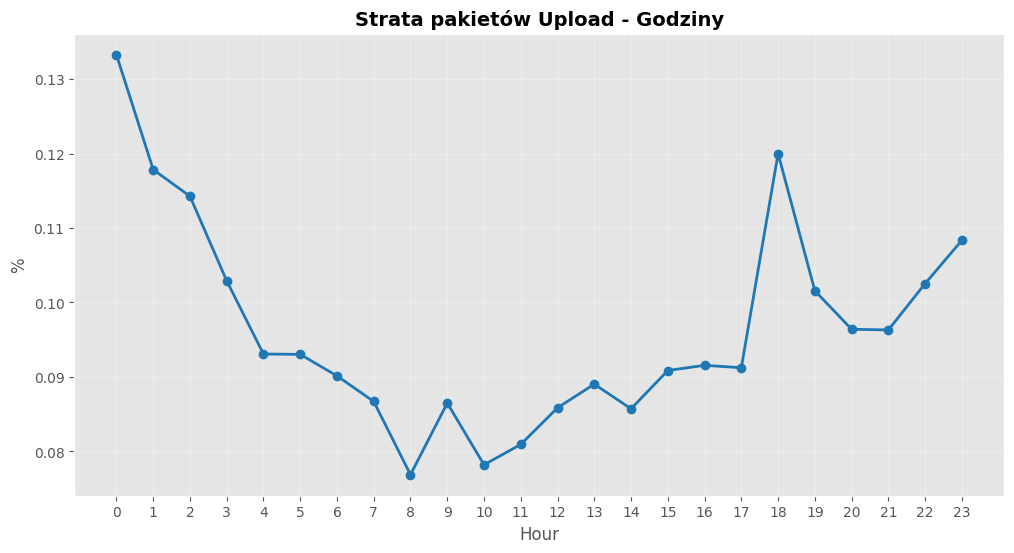

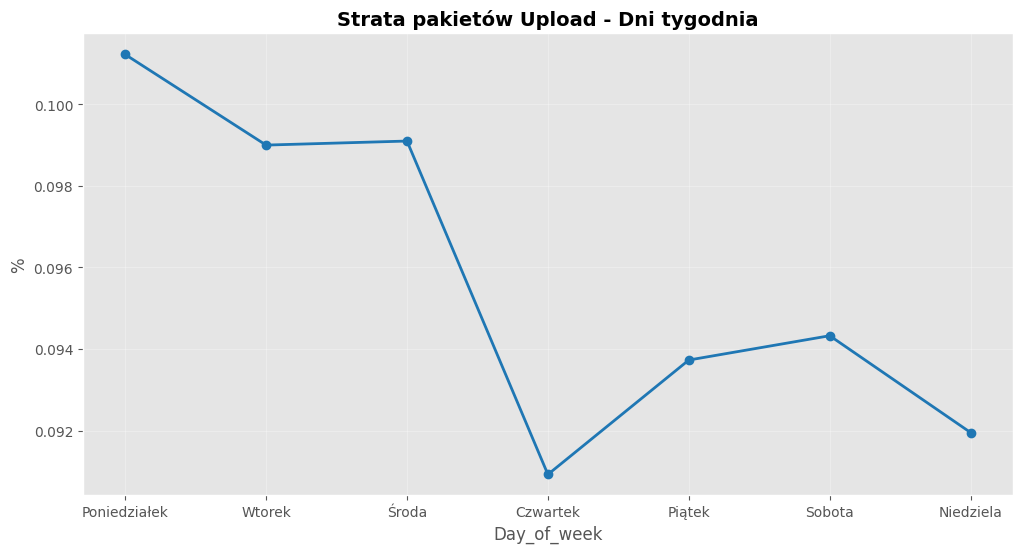

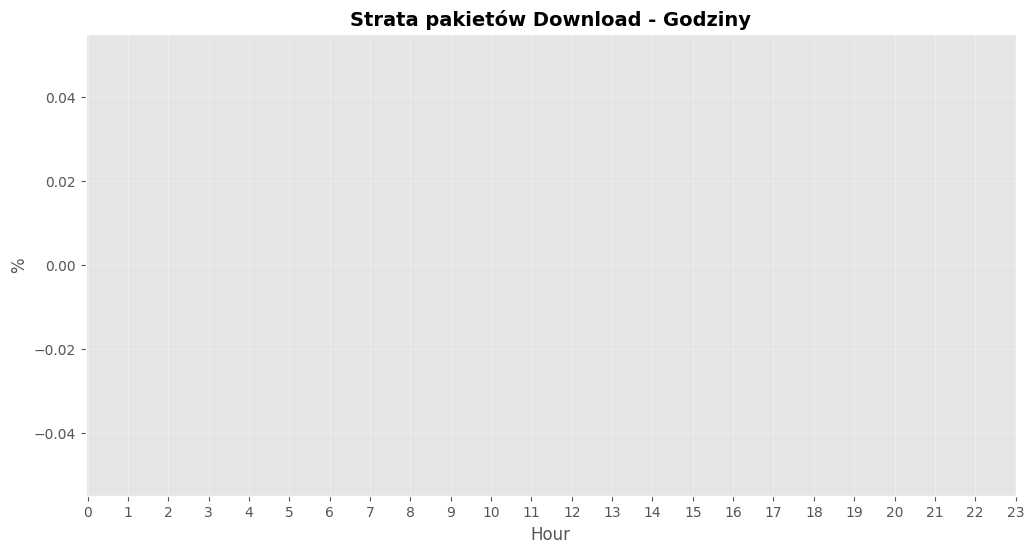

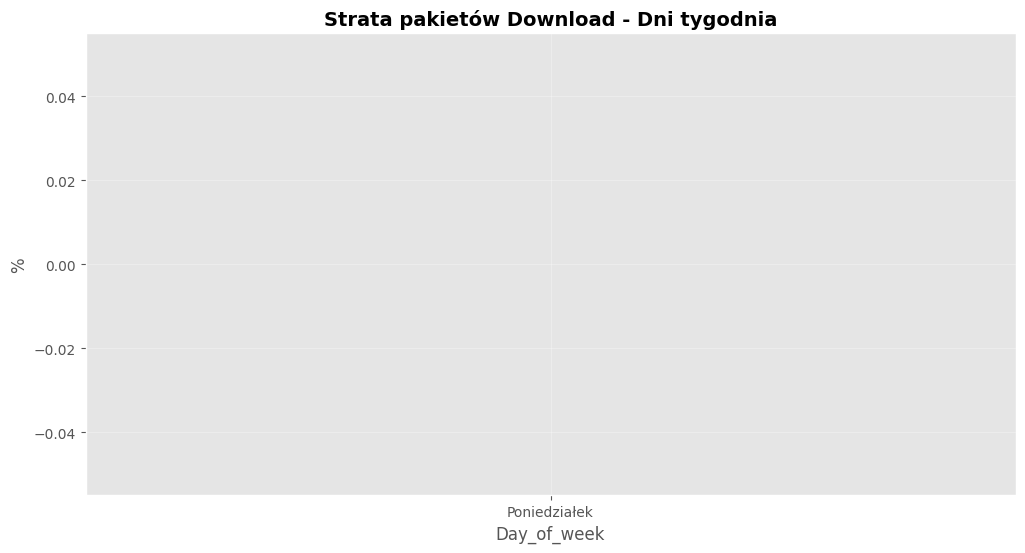

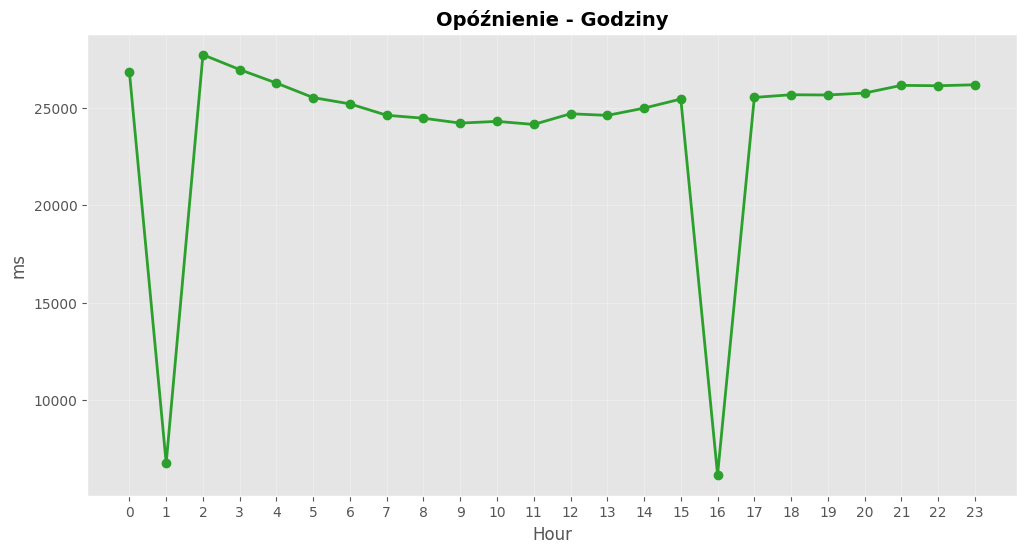

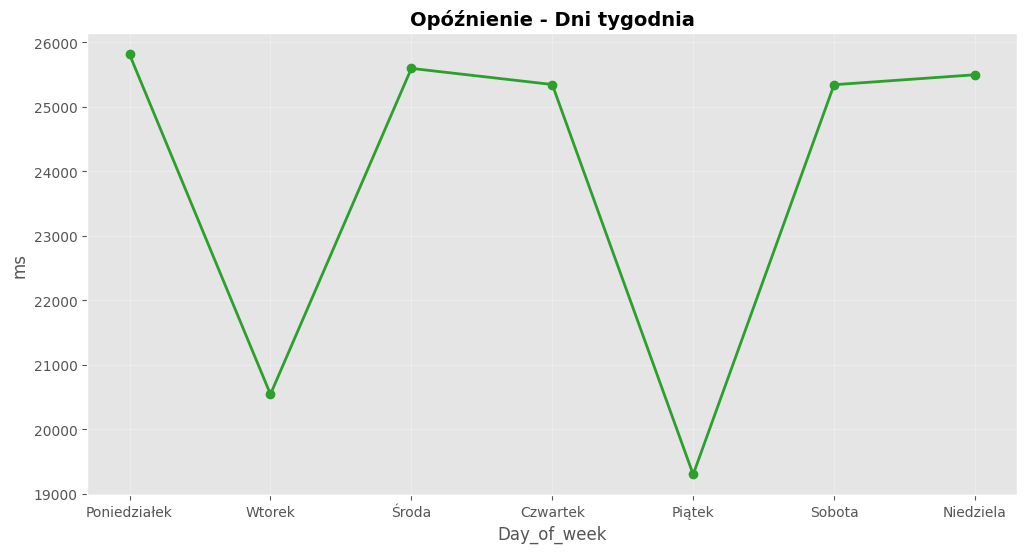

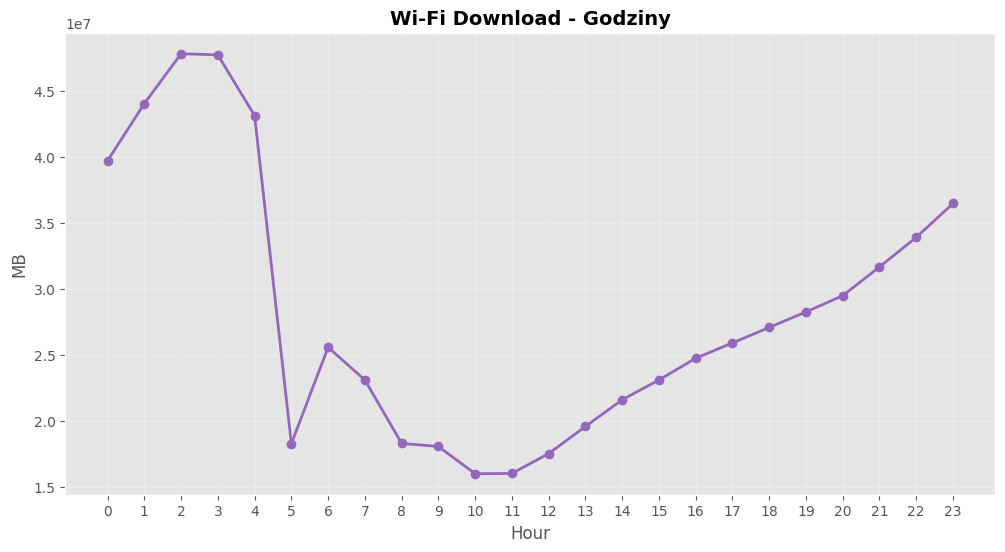

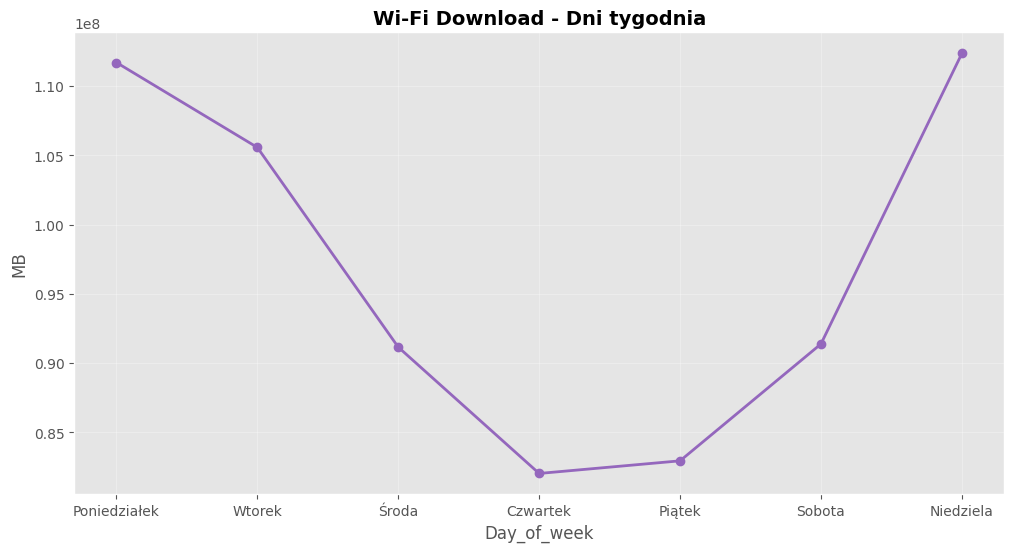

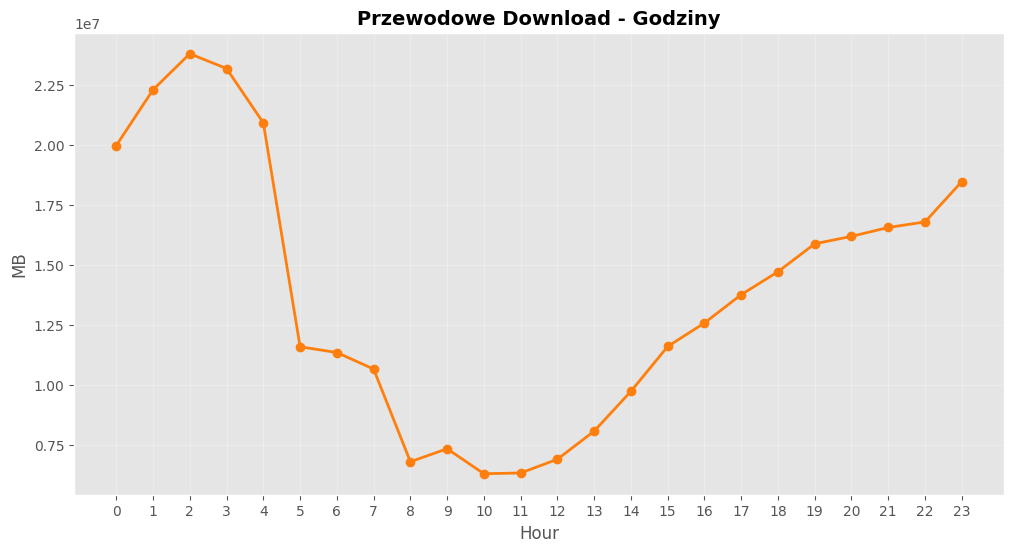

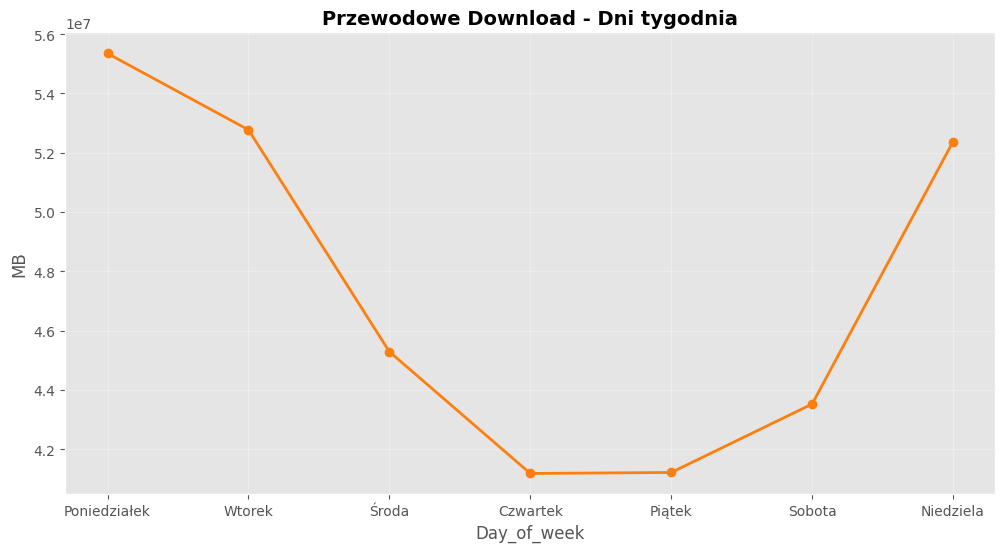

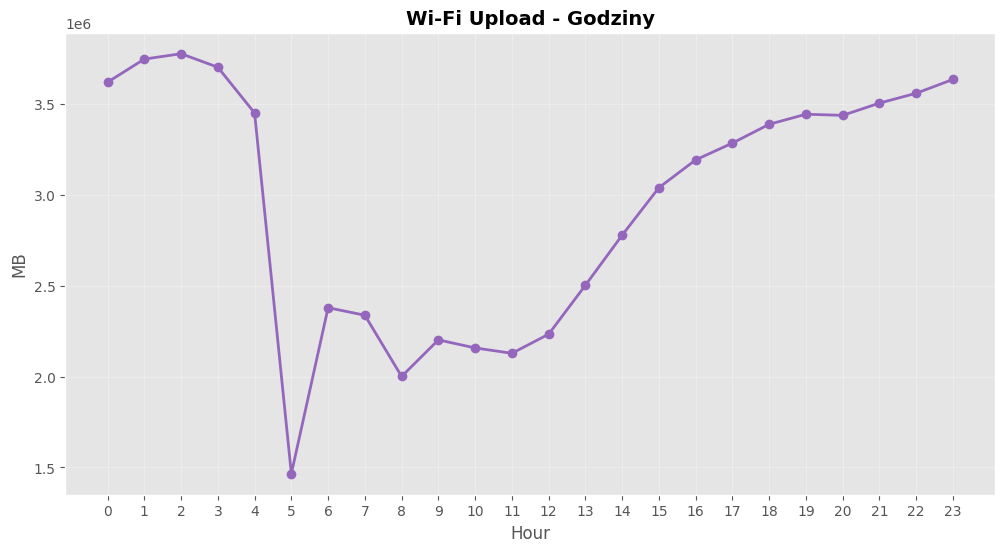

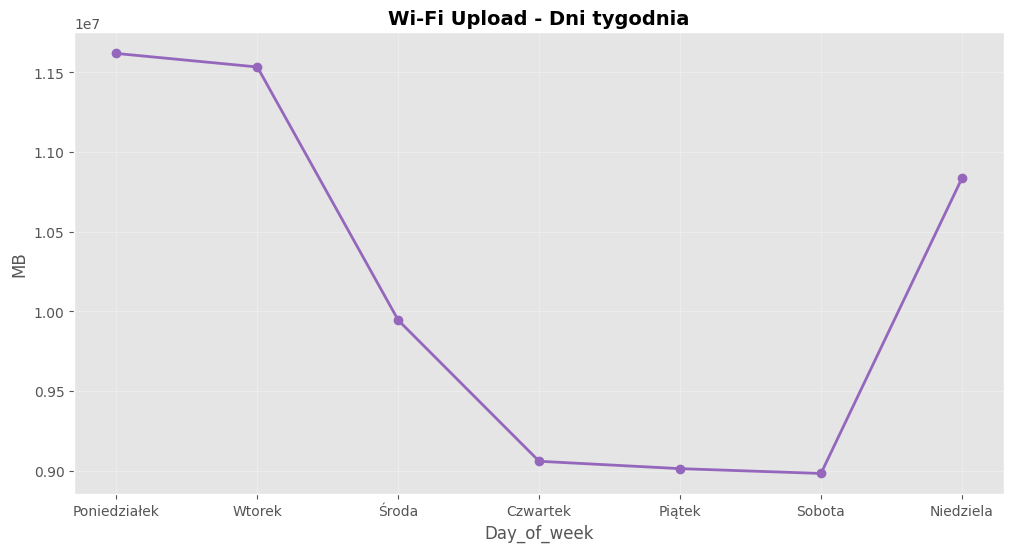

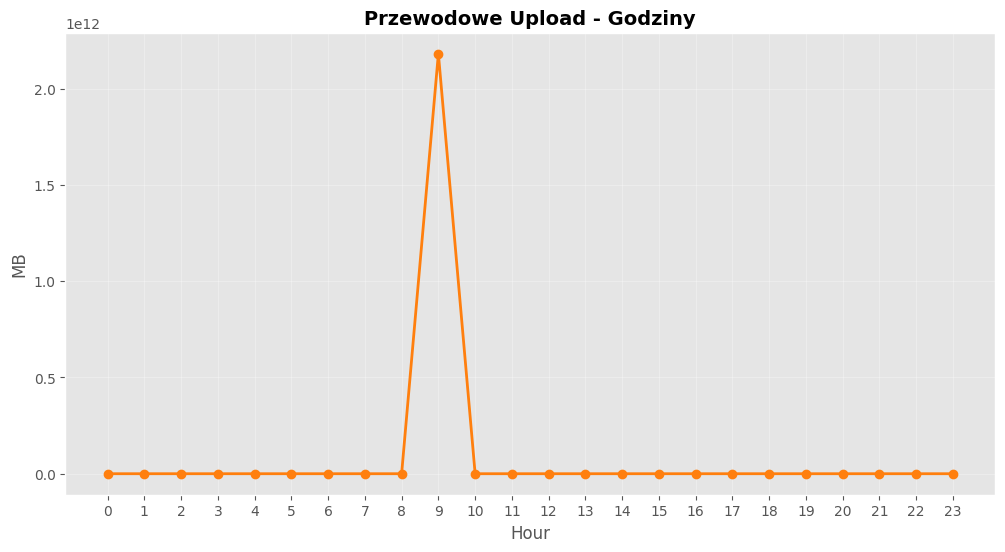

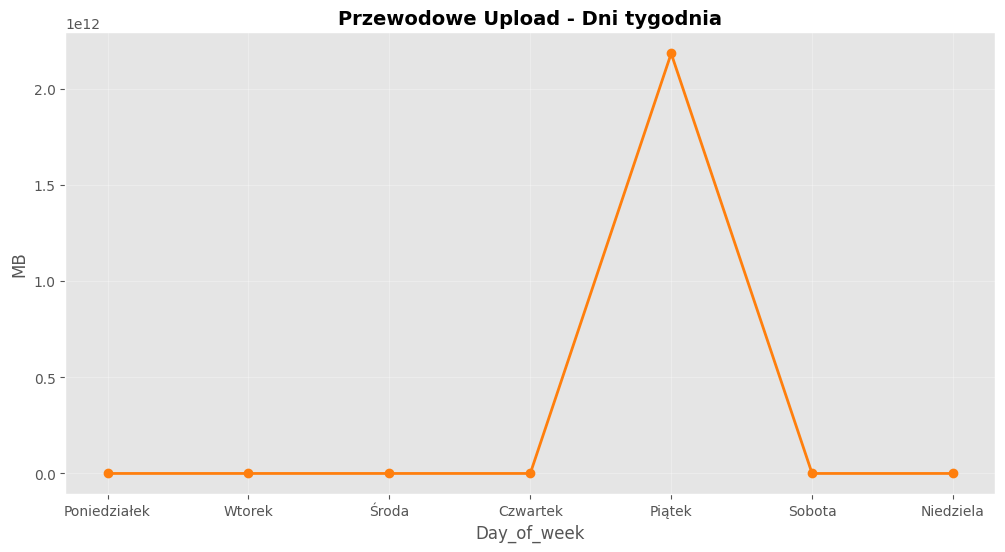

In [1]:
# -*- coding: utf-8 -*-
# Wspólne importy i konfiguracja
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Globalna konfiguracja stylu
plt.style.use('ggplot')
COLORS = {
    'upload': '#1f77b4',
    'download': '#d62728',
    'latency': '#2ca02c',
    'wifi': '#9467bd',
    'wired': '#ff7f0e',
    'http_get': '#17becf',
    'http_post': '#bcbd22'
}
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'grid.alpha': 0.3
})

# Wspólne funkcje pomocnicze
def add_time_columns(df):
    df['hour'] = df['dtime'].dt.hour
    df['day_of_week'] = df['dtime'].dt.dayofweek.map({
        0: 'Poniedziałek', 1: 'Wtorek', 2: 'Środa',
        3: 'Czwartek', 4: 'Piątek', 5: 'Sobota', 6: 'Niedziela'
    })
    return df

def plot_time_series(df, x_col, y_col, title, ylabel, color, marker='o'):
    plt.plot(df[x_col], df[y_col], color=color, marker=marker, linewidth=2)
    plt.title(title)
    plt.xlabel(x_col.capitalize())
    plt.ylabel(ylabel)
    plt.grid(True)

# --------------------------------------------------
# Analiza UDP (udp.ipynb)
# --------------------------------------------------
def analyze_udp():
    jitter_df = pd.read_csv('data/curr_udpjitter.csv', parse_dates=['dtime'])
    jitter_df = add_time_columns(jitter_df)
    
    # Obliczenia strat pakietów
    jitter_df['packet_loss_up'] = (jitter_df['packets_up_sent'] - jitter_df['packets_up_recv']) / jitter_df['packets_up_sent'] * 100
    jitter_df['packet_loss_down'] = (jitter_df['packets_down_sent'] - jitter_df['packets_down_recv']) / jitter_df['packets_down_sent'] * 100

    # Agregacja danych
    hourly_agg = jitter_df.groupby('hour').mean(numeric_only=True).reset_index()
    daily_agg = jitter_df.groupby('day_of_week').mean(numeric_only=True).reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

    
    # Generowanie wykresów
    metrics = [
        ('jitter_up', 'Jitter Upload', COLORS['upload'], 'ms'),
        ('jitter_down', 'Jitter Download', COLORS['download'], 'ms'),
        ('packet_loss_up', 'Strata pakietów Upload', COLORS['upload'], '%'),
        ('packet_loss_down', 'Strata pakietów Download', COLORS['download'], '%'),
        ('latency', 'Opóźnienie', COLORS['latency'], 'ms')
    ]
    
    for col, title_base, color, unit in metrics:
        plt.figure()
        plot_time_series(hourly_agg, 'hour', col, f'{title_base} - Godziny', unit, color)
        plt.xticks(range(0, 24))
        plt.show()
        
        plt.figure()
        plot_time_series(daily_agg, 'day_of_week', col, f'{title_base} - Dni tygodnia', unit, color)
        plt.show()

# --------------------------------------------------
# Analiza HTTP (Wydajność_http.ipynb)
# --------------------------------------------------
def analyze_http():
    httpget = pd.read_csv("data/curr_httpgetmt.csv", parse_dates=["dtime"])
    httppost = pd.read_csv("data/curr_httppostmt.csv", parse_dates=["dtime"])
    
    for df, direction, color in [(httpget, 'download', COLORS['http_get']), 
                               (httppost, 'upload', COLORS['http_post'])]:
        df = add_time_columns(df)
        df['MB/s'] = df['bytes_sec'] / 1e6
        
        hourly_agg = df.groupby('hour')['MB/s'].mean().reset_index()
        daily_agg = df.groupby('day_of_week')['MB/s'].mean().reindex([
        'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
        ]).reset_index()

        
        plt.figure()
        plot_time_series(hourly_agg, 'hour', 'MB/s', 
                        f'HTTP {direction.capitalize()} - Godziny', 'MB/s', color)
        plt.xticks(range(0, 24))
        plt.show()
        
        plt.figure()
        plot_time_series(daily_agg, 'day_of_week', 'MB/s', 
                        f'HTTP {direction.capitalize()} - Dni tygodnia', 'MB/s', color)
        plt.show()

# --------------------------------------------------
# Analiza obciążenia (obciazenie.ipynb)
# --------------------------------------------------
def analyze_load():
    df = pd.read_csv("data/curr_datausage.csv", parse_dates=["dtime"])
    df = add_time_columns(df)
    
    # Konwersja bajtów na MB
    for col in ['cust_wifi_rx_bytes', 'cust_wired_rx_bytes', 
              'cust_wifi_tx_bytes', 'cust_wired_tx_bytes']:
        df[col] = df[col] / 1e6
    
    # Agregacja danych
    connections = [
        ('Wi-Fi Download', 'cust_wifi_rx_bytes', COLORS['wifi']),
        ('Przewodowe Download', 'cust_wired_rx_bytes', COLORS['wired']),
        ('Wi-Fi Upload', 'cust_wifi_tx_bytes', COLORS['wifi']),
        ('Przewodowe Upload', 'cust_wired_tx_bytes', COLORS['wired'])
    ]
    
    for label, col, color in connections:
        hourly_agg = df.groupby('hour')[col].sum().reset_index()
        daily_agg = df.groupby('day_of_week')[col].sum().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

        
        plt.figure()
        plot_time_series(hourly_agg, 'hour', col, 
                        f'{label} - Godziny', 'MB', color)
        plt.xticks(range(0, 24))
        plt.show()
        
        plt.figure()
        plot_time_series(daily_agg, 'day_of_week', col, 
                        f'{label} - Dni tygodnia', 'MB', color)
        plt.show()


analyze_http()
analyze_udp()
analyze_load()

